<a href="https://colab.research.google.com/github/harnalashok/deeplearning-sequences/blob/main/rossmann_timeSeries.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# https://colab.research.google.com/github/duchaba2/fastai_san_ramon_biztech/blob/master/smbt_rossman_data_clean.ipynb#scrollTo=UImWYEGiaFUS
# fastai.core: https://docs.fast.ai/tabular.core.html
# https://www.kaggle.com/hortonhearsafoo/fast-ai-lesson-3
# https://github.com/duchaba2/fastai_san_ramon_biztech

In [ ]:
# Last amended: 17th March, 2021
# My folder: 
# Objectives:
#           i) Predicting sales in Rossmann Store Sales
#          ii) Feature generation in TimeSeries data

# The problem
Rossmann operates over 3,000 drug stores in 7 European countries. Currently, Rossmann store managers are tasked with predicting their daily sales for up to six weeks in advance. Store sales are influenced by many factors, including promotions, competition, school and state holidays, seasonality, and locality. With thousands of individual managers predicting sales based on their unique circumstances, the accuracy of results can be quite varied.

### Field descriptions

Most of the fields are self-explanatory. The following are descriptions for those that aren't.
    
>  **Id** - an Id that represents a (Store, Date) duple within the test set<br>
>  **Store** - a unique Id for each store<br>
>  **Sales** - the turnover for any given day (this is what you are predicting)<br>
>  **Customers** - the number of customers on a given day<br>
>  **Open** - an indicator for whether the store was open: 0 = closed, 1 = open<br>
>  **StateHoliday** - indicates a state holiday. Normally all stores, with few exceptions, are closed on state holidays. Note that all schools are closed on public holidays and weekends. a = public holiday, b = Easter holiday, c = Christmas, 0 = None<br>
>  **SchoolHoliday** - indicates if the (Store, Date) was affected by the closure of public schools<br>
>  **StoreType** - differentiates between 4 different store models: a, b, c, d<br>
>  **Assortment** - describes an assortment level: a = basic, b = extra, c = extended<br>
>   **CompetitionDistance** - distance in meters to the nearest competitor store<br>
>  **CompetitionOpenSince**[Month/Year] - gives the approximate year and month of the time the nearest competitor was opened<br>
>  **Promo** - indicates whether a store is running a promo on that day<br>
> **Promo2** - Promo2 is a continuing and consecutive promotion for some stores: 0 = store is not participating, 1 = store is participating<br>
> **Promo2Since**[Year/Week] - describes the year and calendar week when the store started participating in Promo2<br>
>  **PromoInterval** - describes the consecutive intervals Promo2 is started, naming the months the promotion is started anew. E.g. "Feb,May,Aug,Nov" means each round starts in February, May, August, November of any given year for that store


### Libraries and data files

In [ ]:
#import pytorch and AI
#!pip install --upgrade git+https://github.com/fastai/fastai.git

In [147]:
#(Optional) double check your import pytorch and fast.ai version
# fastai related
# The 'tabular' module has 
#  all the functions as on this page:
#   https://docs.fast.ai/tabular.core.html

from fastai.tabular import *
import fastai
from fastai.tabular import *
from fastai.basics import *
import fastai.utils
#from fastai.data import *

In [148]:
# 1.0 Connect to your google drive
#     Transfer rossmann files from 
#     gdrive to colab VM

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [149]:
# 1.1 Copy files from source to Colab
source="/content/drive/MyDrive/Colab_data_files/rossmannStoreSales"
dest="/content"

# 1.1.1 Remove existing folders
! rm -rf $dest/rossmannStoreSales

# 1.1.2 Copy files from gdrive to colab VM
! cp -r $source $dest/rossmannStoreSales

# 1.1.3 Check
! ls -la $dest/rossmannStoreSales


shell-init: error retrieving current directory: getcwd: cannot access parent directories: No such file or directory
shell-init: error retrieving current directory: getcwd: cannot access parent directories: No such file or directory
shell-init: error retrieving current directory: getcwd: cannot access parent directories: No such file or directory
total 63972
drwx------ 2 root root     4096 Mar 18 09:39 .
drwxr-xr-x 1 root root     4096 Mar 18 09:39 ..
-rw------- 1 root root  7730448 Mar 18 09:39 rossmann.tgz
-rw------- 1 root root 51667341 Mar 18 09:39 stock_prices_nyse.csv
-rw------- 1 root root     8529 Mar 18 09:39 store.csv.zip
-rw------- 1 root root   146686 Mar 18 09:39 test.csv.zip
-rw------- 1 root root  5931096 Mar 18 09:39 train.csv.zip


In [ ]:
# 1.2 Untar tgz file
! tar -xvzf $dest/rossmannStoreSales/rossmann.tgz -C $dest/rossmannStoreSales/

# 1.2.1 And check if all files are there
! ls -la $dest/rossmannStoreSales

In [165]:
# 1.3 Call libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os

In [151]:
# 1.4 Display output of multiple commands from a cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [ ]:
# 1.5 Path to our files
path = "/content/rossmannStoreSales"
os.chdir(path)
os.listdir()

### Read all data

In [ ]:
# 2.0 Read all seven files using pandas
train = pd.read_csv("train.csv")
store = pd.read_csv("store.csv")
weather = pd.read_csv("weather.csv")

# 2.0.1
test = pd.read_csv("test.csv")

# 2.0.2
googletrend = pd.read_csv("googletrend.csv")
state_names = pd.read_csv("state_names.csv")
store_states = pd.read_csv("store_states.csv")

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (7) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [ ]:
# 2.0.3 Also set options to display all rows/all columns
pd.set_option('display.max_columns', None)  # or 1000
pd.set_option('display.max_rows', None)  # or 1000
pd.set_option('display.max_colwidth', None)  # or 199

### Explore train data

In [ ]:
# 2.1 Look at train data
print("\n---train----\n")
train.shape         # (1017209, 9)
print("\n------train------\n")
train.head()
print("\n-----Summary------\n")
train.describe()
print("\n-----dtypes------\n")
train.dtypes

In [ ]:
# 2.2
train['Store'].nunique()             # 1115
print()
train['Promo'].nunique()             # 2
train['Promo'].unique()              # [1,0] 
print()
train['Open'].nunique()              # 2
train['Open'].unique()               # [1,0]
print()
train['SchoolHoliday'].nunique()     # 2
train['SchoolHoliday'].unique()
print()
train['StateHoliday'].nunique()      # 5
train['StateHoliday'].unique()       # ['0', 'a', 'b', 'c', 0]
print()
train['Date'].nunique()              # 942

In [ ]:
# 2.3 About nulls
#     No nulls here
train.isnull().sum()

### Explore Store data

In [ ]:
# 3.0 Look at store data
print("\n---shape----\n")
store.shape         # (1115, 10)
print("\n------data------\n")
store.head()
print("\n-----Summary------\n")
store.describe()
print("\n-----dtypes------\n")
store.dtypes

In [ ]:
# 3.1
store['StoreType'].unique()     # ['c', 'a', 'd', 'b']
print()
store['Assortment'].unique()    # ['a', 'c', 'b']
print()
store['Promo2'].unique()        # [0,1]
print()
np.sort(store['CompetitionOpenSinceYear'].unique()) # Large number of years from 1961, 1990 to 2015
                                                    #  excluding NaN and 1900

In [ ]:
# 3.2 Whenever Promo2 is zero, three other columns carry NaN values
store.loc[store['Promo2'] == 0, ['Promo2','Promo2SinceWeek','Promo2SinceYear', 'PromoInterval']].head(5)
print()
store.isnull().sum()

In [ ]:
# 3.3 Three cases where CompetitionDistance is NULL
#     CompetitionOpenSinceMonth and CompetitionOpenSinceYear
#     are also NULL

store.loc[store['CompetitionDistance'].isnull() , :].head()

### Explore weather data

In [ ]:
# 4.0 Look at weather data
print("\n---shape----\n")
weather.shape         # (15840, 24)
print("\n------data------\n")
weather.head()
print("\n-----Summary------\n")
weather.describe()
print("\n-----dtypes------\n")
weather.dtypes

In [ ]:
# 4.1 Unique values for object features
weather['file'].nunique()     # 16
print()
weather['Date'].nunique()     # 990 Some dates are repeating for some 'file'
print()
weather['Events'].nunique()   # 21 unique weather events

16

990

21

In [ ]:
# 4.2 Null values
#     Some columns have NULL values
#     Max_Gust_SpeedKm_h has very large number of NULL values
#     Events: In 3951 cases no Events recorded
weather.isnull().sum().sort_values(ascending = False).head(10)

### Google trends and other data

#### Explore googletrends

In [ ]:
# 5.0 Look at googletrend data
print("\n---google trends----\n")
googletrend.shape         # (1017209, 9)
print()
googletrend.head()        # (15840, 24)
print()
googletrend.dtypes

In [ ]:
# 5.1 A little more 
googletrend['week'].nunique()   # 148
print()
googletrend['file'].nunique()   # 14

#### Split up '*week*' and '*file*' columns of googletrend
This will create new columns. In pandas you can add new columns to a dataframe by simply defining it. We'll do this for googletrends by extracting dates and state names from the given data and adding those columns.

We're also going to replace all instances of state name 'NI' to match the usage in the rest of the data: 'HB,NI'. This is a good opportunity to highlight pandas indexing. We can use .loc[rows, cols] to select a list of rows and a list of columns from the dataframe. In this case, we're selecting rows w/ statename 'NI' by using a boolean list googletrend.State=='NI' and selecting "State".


---



In [ ]:
# 6.0
# Refer" # https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.str.split.html
#  String split with 'expand'
googletrend.week.str.split(
                           ' - ',         # split on this '_'
                           expand = True  # Each split part is a column now
                           )[0].head(2)   # select the first split part as a column & display


0    2012-12-02
1    2012-12-09
Name: 0, dtype: object

In [ ]:
# 6.1 Split 'week' field at ' - '
googletrend['Date'] = googletrend.week.str.split(' - ', expand=True)[0]

# 6.2 Split 'file' field at '_' and capture the 2nd index as new column
googletrend['State'] = googletrend.file.str.split('_', expand=True)[2]

# 6.3
googletrend.loc[googletrend.State=='NI', "State"] = 'HB,NI'
googletrend.head()

# 6.4 Also check if any 'NI' remaining
np.sum(googletrend.State=='NI')  # 0

,file,week,trend,Date,State
0,Rossmann_DE_SN,2012-12-02 - 2012-12-08,96,2012-12-02,SN
1,Rossmann_DE_SN,2012-12-09 - 2012-12-15,95,2012-12-09,SN
2,Rossmann_DE_SN,2012-12-16 - 2012-12-22,91,2012-12-16,SN
3,Rossmann_DE_SN,2012-12-23 - 2012-12-29,48,2012-12-23,SN
4,Rossmann_DE_SN,2012-12-30 - 2013-01-05,67,2012-12-30,SN


0

In [ ]:
# 6.4.1
googletrend.head(10)

,file,week,trend,Date,State
0,Rossmann_DE_SN,2012-12-02 - 2012-12-08,96,2012-12-02,SN
1,Rossmann_DE_SN,2012-12-09 - 2012-12-15,95,2012-12-09,SN
2,Rossmann_DE_SN,2012-12-16 - 2012-12-22,91,2012-12-16,SN
3,Rossmann_DE_SN,2012-12-23 - 2012-12-29,48,2012-12-23,SN
4,Rossmann_DE_SN,2012-12-30 - 2013-01-05,67,2012-12-30,SN
5,Rossmann_DE_SN,2013-01-06 - 2013-01-12,71,2013-01-06,SN
6,Rossmann_DE_SN,2013-01-13 - 2013-01-19,53,2013-01-13,SN
7,Rossmann_DE_SN,2013-01-20 - 2013-01-26,58,2013-01-20,SN
8,Rossmann_DE_SN,2013-01-27 - 2013-02-02,55,2013-01-27,SN
9,Rossmann_DE_SN,2013-02-03 - 2013-02-09,55,2013-02-03,SN


### More explorations

In [ ]:
# 7.0 
state_names.head()
print()
state_names.State.nunique() # 16
print()
store_states.head()
print()
store_states['Store'].nunique()   # 1115
print()
store_states['State'].nunique()   # 12

In [ ]:
# 7.1 StateHoliday
train.StateHoliday.dtype
print()
train.StateHoliday[:4]

### Transform *StateHoliday* field
We turn state Holidays to booleans, to make them more convenient for modeling. We can do calculations on pandas fields using notation very similar (often identical) to numpy.

In [ ]:
# 7.2 StateHoliday replace by True/False
train.StateHoliday = train.StateHoliday!='0'
train.StateHoliday[:4]
print()
# 7.2.1
test.StateHoliday = test.StateHoliday!='0'
test.StateHoliday[:4]

0    False
1    False
2    False
3    False
Name: StateHoliday, dtype: bool

0    False
1    False
2    False
3    False
Name: StateHoliday, dtype: bool

### Date components

#### `add_datepart()` [fastai](https://github.com/fastai/fastai/blob/master/fastai/tabular/core.py#L15) function
The following extracts particular date fields from a complete datetime for the purpose of constructing categoricals.

You should ***always*** consider this feature extraction step when working with date-time. Without expanding your date-time into these additional fields, you can't capture any trend/cyclical behavior as a function of time at any of these granularities. We'll add to every table with a date field.

In [ ]:
# 8.0
## add_datepart()
# Break every date-field is broken into multiple components:
# ['Year', 'Month', 'Week', 'Day', 'Dayofweek', 'Dayofyear',
#  'Is_month_end', 'Is_month_start', 'Is_quarter_end', 
#  'Is_quarter_start', 'Is_year_end', 'Is_year_start']
#
# Source: https://colab.research.google.com/github/duchaba2/fastai_san_ramon_biztech/blob/master/smbt_rossman_data_clean.ipynb#scrollTo=AgmbiE0MR8LE

import re
def add_datepart(df, fldname, drop=True, time=False):
    "Helper function that adds columns relevant to a date."

    fld = df[fldname]
    fld_dtype = fld.dtype

    # If date-field in not of 'date' type,
    #  transform it
    if isinstance(fld_dtype, pd.core.dtypes.dtypes.DatetimeTZDtype):
        fld_dtype = np.datetime64

    if not np.issubdtype(fld_dtype, np.datetime64):
        df[fldname] = fld = pd.to_datetime(fld, infer_datetime_format=True)

    targ_pre = re.sub('[Dd]ate$', '', fldname)
    attr = [
             'Year', 'Month', 'Week', 'Day', 'Dayofweek', 'Dayofyear',
             'Is_month_end', 'Is_month_start', 'Is_quarter_end', 
             'Is_quarter_start', 'Is_year_end', 'Is_year_start'
             ]

    if time:
       attr = attr + ['Hour', 'Minute', 'Second']
    
    # Begin attribute extraction using '.dt. accessor
    for n in attr: 
      df[targ_pre + n] = getattr(fld.dt, n.lower())

    df[targ_pre + 'Elapsed'] = fld.astype(np.int64) // 10 ** 9
    
    # If original date-field is to be dropped, drop it
    if drop: 
      df.drop(fldname, axis=1, inplace=True)

In [ ]:
# 8.1  Using above function, breakup
#      'dates' in all cases below
add_datepart(train, "Date", drop=False)
# 8.1.1
add_datepart(test, "Date", drop=False)
# 8.1.2
add_datepart(weather, "Date", drop=False)
# 8.1.3
add_datepart(googletrend, "Date", drop=False)
# 8.1.4
add_datepart(weather, "Date", drop=False)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.


In [ ]:
# 8.2 So what are the revised data shapes
train.shape    # (1017209, 22)
print()
test.shape     # (41088, 21)
print()
weather.shape    # (15840, 37)
print()
googletrend.shape # (2072, 18)
print()
# 8.3 And look at one data
train.head()

The Google trends data has a special category for the whole of the Germany - we'll pull that out so we can use it explicitly.

In [ ]:
# 8.4
googletrend.shape  # (2072, 18)
googletrend.head()
print()
trend_de = googletrend[googletrend.file == 'Rossmann_DE']
trend_de.shape    # (148, 18)
print()
trend_de.head()

### Joining tables

`join_df` is a function for joining tables on specific fields. By default, we'll be doing a left outer join of right on the left argument using the given fields for each table. Pandas does joins using the merge method. The suffixes argument describes the naming convention for duplicate fields. We've elected to leave the duplicate field names on the left untouched, and append a "_y" to those on the right.

In [ ]:
# 9.0 Define a small function for merging tables
# df.merge(right,
#          how='inner',
#          left_on=None,     # Column or index level names to join on in the left DataFrame
#          right_on=None,    # Column or index level names to join on in the right DataFrame.
#          suffixes=('_x', '_y')) #  a string indicating the suffix to add to overlapping column name

def join_df(leftTable, rightTable, left_onField, right_onField=None, suffix='_y'):

    # 9.0.1 Both right and left fields would be same
    if right_onField is None: 
      right_onField = left_onField  # Both sides are same

    # 9.0.2 Return merged table  
    return leftTable.merge(
                            rightTable,
                            how='left',            # It is 'left' join AND NOT 'inner' join
                                                   # We cannot loose left-side data
                            left_on=left_onField,     
                            right_on=right_onField, 
                            suffixes=("", suffix)   # left side: no suffix, 
                                                    # right side default is "_y"
                                                    # unless mentioned in the function
                                                    # call arguments 
                            )
    

In [ ]:
# 9.1 Join1: (weather + state_names)
#     join_df(leftTable, rightTable, left_onField, right_onField=None, suffix='_y')

weather.shape    # (15840, 37)

print()

# 9.2 Suffix is "_y":
weather = join_df(weather,     # Left df
                  state_names, # right df
                  "file",      # Ist column of 'weather': Contains state names
                  "StateName"  # Ist column of 'state_name'
                  )

print()

# 9.3
weather.shape   # (15840, 37+2)

In [ ]:
# 9.4 Columns 'file' and 'StateName' are the same:

weather.head(2) # Both 'file' and 'StateName' columns have same data

In [ ]:
# 9.5 Join2: (store + stire_states)
#     join_df(leftTable, rightTable, left_onField, right_onField=None, suffix='_y')
store.shape    # (1115, 10)
print()
store = join_df(store,
                store_states,
                "Store"
                )
print()
store.shape    # (1115, 11)

In [ ]:
# 9.5.1 Check point
weather.shape  # (15840, 39)
store.shape    # (1115, 11)
train.shape    # (1017209, 22)
# Delete any earlier 'joined'
del joined

In [ ]:
# 9.6 join3: (train+store)
#     join_df(leftTable, rightTable, left_onField, right_onField=None, suffix='_y')

train.shape    # (1017209, 22)
print()
joined = join_df(train,
                 store,
                 "Store"
                 )

joined_test = join_df(test, store, "Store")
len(joined[joined.StoreType.isnull()]),len(joined_test[joined_test.StoreType.isnull()])  # (0, 0)
joined.shape   # (1017209, 32)
print()
joined_test.shape # (41088, 31)

In [ ]:
# 9.6.1 Check point
weather.shape  # (15840, 39)
store.shape    # (1115, 11)
train.shape    # (1017209, 22)
joined.shape   # (1017209, 32)

In [ ]:
# 9.7 join4: (joined+googletrend)
joined.shape  # (1017209, 32)
print()
joined = join_df(
                 joined,
                 googletrend,
                 ["State","Year", "Week"] # Left fields to be joined on
                 )

joined_test = join_df(joined_test, googletrend, ["State","Year", "Week"])
len(joined[joined.trend.isnull()]),len(joined_test[joined_test.trend.isnull()])
joined.shape  # (1017209, 47)
print()
joined_test.shape  # (41088, 46)

In [ ]:
# 9.7.1 Check point
weather.shape  # (15840, 39)
store.shape    # (1115, 11)
train.shape    # (1017209, 22)
joined.shape   # (1017209, 47)

In [ ]:
#9.8
# join5: (joined+trend_de)  Note the suffix here. It is NOT the default '_y'
#       join_df(leftTable, rightTable, left_onField, right_onField=None, suffix='_y')
joined.shape   # (1017209, 47)

# Use pandas pd.merge here:
joined = joined.merge(
                      trend_de,          # Right table
                      'left',            # type of join
                      ["Year", "Week"],  # On these two fields
                      suffixes=('', '_DE')
                      )

joined_test = joined_test.merge(trend_de, 'left', ["Year", "Week"], suffixes=('', '_DE'))
len(joined[joined.trend_DE.isnull()]),len(joined_test[joined_test.trend_DE.isnull()])  # 
joined.shape   # (1017209, 63)
joined_test.shape  # (41088, 62)

In [ ]:
# 9.8.1 Check point
weather.shape  # (15840, 39)
store.shape    # (1115, 11)
train.shape    # (1017209, 22)
joined.shape   # (1017209, 63)

In [ ]:
#9.9
#join6: (joined+weather)
#       join_df(leftTable, rightTable, left_onField, right_onField=None, suffix='_y')

joined.shape       # (1017209, 63)
joined = join_df(
                 joined,
                 weather,
                 ["State","Date"]
                 )

joined_test = join_df(joined_test, weather, ["State","Date"])
len(joined[joined.Mean_TemperatureC.isnull()]),len(joined_test[joined_test.Mean_TemperatureC.isnull()]) # (0,0)
joined.shape       # (1017209, 100)
joined_test.shape  # (41088, 99)

In [ ]:
# 9.9.1 Check point
weather.shape  # (15840, 39)
store.shape    # (1115, 11)
train.shape    # (1017209, 22)
joined.shape   # (1017209, 100)

In [ ]:
# 9.10 Check
joined.columns
len(joined.columns)   # 100

# 9.11 Assign value to 'name' attribute of DataFrame
#      We will use it shortly
joined.name = "joined"
joined_test.name = "joined_test"

In [ ]:
# 10.0 Remove columns having suffix of '_y'

for df in (joined, joined_test):
    for c in df.columns:
        if c.endswith('_y'):
            if c in df.columns:
              print(c,df.name)
              df.drop(c, inplace=True, axis=1)

In [ ]:
# 10.0.1
# Check point
weather.shape  # (15840, 39)
store.shape    # (1115, 11)
train.shape    # (1017209, 22)
joined.shape       # (1017209, 74)
joined_test.shape  # (41088, 73)

### Missing values
Next we'll fill in missing values to avoid complications with `NA`'s. `NA` (not available) is how Pandas indicates missing values; many models have problems when missing values are present, so it's always important to think about how to deal with them. In these cases, we are picking an arbitrary *signal value* that doesn't otherwise appear in the data.

In [ ]:
# 11.0 Just explore
joined[['CompetitionOpenSinceYear', 'CompetitionOpenSinceMonth', 'Promo2SinceYear', 'Promo2SinceWeek']].head(5)
joined[['CompetitionOpenSinceYear', 'CompetitionOpenSinceMonth', 'Promo2SinceYear', 'Promo2SinceWeek']].describe()

In [ ]:
# 11.1
for df in (joined,joined_test):

    ##AA. 'CompetitionOpenSinceYear' & 'CompetitionOpenSinceMonth'
    ##     15/01/1900   ==== 354 missing values each
    # Fill in year as 1900 (354 missing values)
    df['CompetitionOpenSinceYear'] = df.CompetitionOpenSinceYear.fillna(1900).astype(np.int32)
    # Fill in month as 1 (354 missing values)
    df['CompetitionOpenSinceMonth'] = df.CompetitionOpenSinceMonth.fillna(1).astype(np.int32)

    ##BB. 'Promo2SinceYear' and 'Promo2SinceWeek'
    #      01/01/1900    ==== 544 missing values
    # Fill in year as 1900. (544 missing values)
    df['Promo2SinceYear'] = df.Promo2SinceYear.fillna(1900).astype(np.int32)
    # Fill in week as 1. (544 missing values)
    df['Promo2SinceWeek'] = df.Promo2SinceWeek.fillna(1).astype(np.int32)

In [ ]:
# 12. We create a new feature from these two features
joined[['Date','CompetitionOpenSinceYear','CompetitionOpenSinceMonth'] ].head()

In [ ]:
# 12.1 Create two features: One new date feature 
#                           and one 'days' elapsed feature:

for df in (joined,joined_test):
    # 12.1 Create a new feature 'CompetitionOpenSince'
    #       CompetitionOpenSince whose year is CompetitionOpenSinceYear
    #        and whose month is CompetitionOpenSinceMonth and the 
    #         day is 15 (selected randomly)
    df["CompetitionOpenSince"] = pd.to_datetime(
                                                 dict
                                                     (
                                                       year=df.CompetitionOpenSinceYear, 
                                                       month=df.CompetitionOpenSinceMonth,
                                                       day=15   # This is an arbitrary selection
                                                     )
                                                )
    # 12.2 Another feature. Days elapsed from 'CompetitionOpenSince' to current 'date'
    df["CompetitionDaysOpen"] = df.Date.subtract(df.CompetitionOpenSince).dt.days

In [ ]:
# 12.3 Some cleaning of data:

for df in (joined,joined_test):
    # CompetitionDaysOpen feature was just created (See above)
    df.loc[df.CompetitionDaysOpen<0, "CompetitionDaysOpen"] = 0
    # Also before 1990 setting CompetitionDaysOpen as 0
    #  The earliest CompetitionOpenSinceYear  is 1990
    df.loc[df.CompetitionOpenSinceYear<1990, "CompetitionDaysOpen"] = 0

In [ ]:
# 12.3.1
joined.shape   # (1017209, 76)
print()
import sys
np.set_printoptions(threshold=sys.maxsize)
np.sort(joined.columns.values)

#### Save processed data to disk

In [ ]:
# Save data to disk
# StackOverflow: https://stackoverflow.com/a/17098736/3282777

path = "/content/drive/MyDrive/Colab_data_files/"
joined.to_pickle(path +"joined")
joined_test.to_pickle(path +"joined_test")

In [ ]:
# Check saved files
!ls -la $path 

In [116]:
del joined
del joined_test

### Read processed data from disk

In [117]:
# Read saved files
path = "/content/drive/MyDrive/Colab_data_files/"
joined = pd.read_pickle(path +"joined")
joined_test =pd.read_pickle(path +"joined_test")

In [ ]:
joined.shape    # (1017209, 76)
joined_test.shape  # (41088, 75)

## Feature creation

### Elapsed time



It is common when working with time series data to extract data that explains relationships across rows as opposed to columns, e.g.:
* Running averages
* Time until next event
* Time since last event

This is often difficult to do with most table manipulation frameworks, since they are designed to work with relationships across columns. As such, we've created a class to handle this type of data.

We'll define a function `get_elapsed` for cumulative counting across a sorted dataframe. Given a particular field `fld` to monitor, this function will start tracking time since the last occurrence of that field. When the field is seen again, the counter is set to zero.

Upon initialization, this will result in datetime na's until the field is encountered. This is reset every time a new store is seen. We'll see how to use this shortly.  

Let's walk through an example.

Say we're looking at School Holiday. We'll first sort by Store, then Date, and then call `add_elapsed('SchoolHoliday', 'After')`:
This will apply to each row with School Holiday:
* A applied to every row of the dataframe in order of store and date
* Will add to the dataframe the days since seeing a School Holiday
* If we sort in the other direction, this will count the days until another holiday.

The following figure is from this [link](https://docs.fast.ai/tabular.core.html#add_elapsed_times):

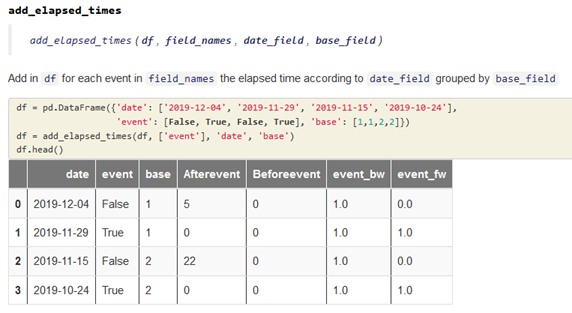

<br>
The implementiation details written as a pseudo-code are as given below:

Pseudo-code

```
Initialize
last_store_Seen    = 0
last_date_recorded = np.datetime64() 

1. Read current store number: csn
2. Read current SchoolHoliday value: sh_value
3. Read current Date: c_date
Begin  
Is csn == last_store_seen
  if NO:   
          last_store_seen = csn
          after = 0
          is sh_value == True
            if Yes, last_date_recorded = c_date
            if No---last_date_recorded = np.datetime64() 
   if YES:
          is sh_value == True
            if Yes, last_date_recorded = c_date
            after = 0
            if False, after = c_date - last_date_recorded

```





In [79]:
# 13.0 We are NOT using this function. But worth examining.
#      The source code of the following function is here:
#      https://github.com/fastai/fastai/blob/master/fastai/tabular/core.py#L54
# Usage: https://docs.fast.ai/tabular.core.html#add_elapsed_times
#
#      We are NOT using this function, but it is worth trying.
#      Other useful functions are at above link.

def add_elapsed_times(df, field_names, date_field, base_field):
    "Add in `df` for each event in `field_names` the elapsed time according to `date_field` grouped by `base_field`"
    field_names = list((field_names))
    #Make sure date_field is a date and base_field a bool
    df[field_names] = df[field_names].astype('bool')
    make_date(df, date_field)

    work_df = df[field_names + [date_field, base_field]]
    work_df = work_df.sort_values([base_field, date_field])
    work_df = _get_elapsed(work_df, field_names, date_field, base_field, 'After')
    work_df = work_df.sort_values([base_field, date_field], ascending=[True, False])
    work_df = _get_elapsed(work_df, field_names, date_field, base_field, 'Before')

    for a in ['After' + f for f in field_names] + ['Before' + f for f in field_names]:
        work_df[a] = work_df[a].fillna(0).astype(int)

    for a,s in zip([True, False], ['_bw', '_fw']):
        work_df = work_df.set_index(date_field)
        tmp = (work_df[[base_field] + field_names].sort_index(ascending=a)
                      .groupby(base_field).rolling(7, min_periods=1).sum())
        tmp.drop(base_field,1,inplace=True)
        tmp.reset_index(inplace=True)
        work_df.reset_index(inplace=True)
        work_df = work_df.merge(tmp, 'left', [date_field, base_field], suffixes=['', s])
    work_df.drop(field_names,1,inplace=True)
    return df.merge(work_df, 'left', [date_field, base_field])

#### Our get_event_elapsed function

In [119]:
# 13.1 See StackOverflow
#      https://stackoverflow.com/a/18215499/3282777

def get_event_elapsed(base_fld, event_fld, dt_fld, df):
  """
  Example:
   base_fld = 'Store'        For every store
   fld = 'SchoolHoliday'     when this event happens, switch on your stop-watch
                               The stop-watch adds a day for each passing day, till
                                next this event happens. At that time reset stop-watch
                                 This is 'After-field'
   dt_fld=Date field                             
   
   How many days, hence, the next event will happen
   To calculate this, put data in descending  order
   date-wise and apply the algorithm, as if for 'After-field'
   So for a given 'Store', next 'SchoolHoliday'
   has come After how many days since the last

  """
  # 13.2 Initialise all variables
  day1 = np.timedelta64(1, 'D')        # See expt below
  last_store_seen = 0                  # This store does not exist
  last_date_recorded = np.datetime64() # Nat: Not a time (same as None)
  after = 0                            # Initial value in 'after' field
  res = []                             # Collection of all values
                                       # as we move forward in time

  for csn,sh_value,c_date in zip(df[base_fld].values,df[event_fld].values,df[dt_fld].values):
    # Get current store
    if csn != last_store_seen:
      after = 0
      last_store_seen = csn
      if sh_value:
        last_date_recorded = c_date
      else:
        last_date_recorded = np.datetime64()
    else:
      if sh_value:
        last_date_recorded = c_date
        after =0
      else:
        """
        StackOverFlow: https://stackoverflow.com/a/18215499/3282777
        In the absence of division by day1
        we get the following: 
        numpy.timedelta64(1,'D'),
        numpy.timedelta64(2,'D'),
        numpy.timedelta64(3,'D'),
        numpy.timedelta64(4,'D'),
        """
        after = (c_date - last_date_recorded).astype('timedelta64[D]') /  day1
    res.append(after)
  return(res)    
  


#### Simple experiments

In [81]:
# 14.0 Here is 
print(np.timedelta64(1, 'D'))  # 1 days
print(type(np.timedelta64(1, 'D')))   # It is a timedelta type
print(np.datetime64())         # NaT

1 days
<class 'numpy.timedelta64'>
NaT


In [217]:
# 14.1 Create a date-range from 1st March to 16th March
dr = pd.date_range(start = '03/01/2021', end = '03/16/2021').to_list()
# 14.1.1 Create a data-frame
xy = pd.DataFrame(
                    {
                      "event" : [1,0,1,1,0,1, 0,0,0,0,1,1, 0,0,1,0] * 2, 
                      "date_fld" : dr * 2,
                      "base_fld" : [1]* 16 + [2]* 16
                    }
                  )
# 14.1.2
xy.shape   # (32, 3)
xy.head()
xy.tail()

# 14.1.3 Shuffle the DataFrame rows 
xy = xy.sample(frac = 1)  
xy.head()

(32, 3)

,event,date_fld,base_fld
0,1,2021-03-01,1
1,0,2021-03-02,1
2,1,2021-03-03,1
3,1,2021-03-04,1
4,0,2021-03-05,1


,event,date_fld,base_fld
27,1,2021-03-12,2
28,0,2021-03-13,2
29,0,2021-03-14,2
30,1,2021-03-15,2
31,0,2021-03-16,2


,event,date_fld,base_fld
29,0,2021-03-14,2
16,1,2021-03-01,2
26,1,2021-03-11,2
5,1,2021-03-06,1
10,1,2021-03-11,1


In [ ]:
# 14.2 Sort our dataset on ['base_fld','date_fld'] 
#      dates in ascending order
xy = xy.sort_values(['base_fld','date_fld'])

# 14.3 Then apply our function
#      get_event_elapsed(grfld, event_fld, dt_fld, df)

# 14.4
xy['after_event']= get_event_elapsed('base_fld','event', 'date_fld', xy )
xy

In [ ]:
# 14.4 Sort database with dates in descending order
xy = xy.sort_values(['base_fld','date_fld'], ascending = [True,False])

# 14.5 Now apply
#     get_event_elapsed(grfld, event_fld, dt_fld, df)
xy['before_event']= get_event_elapsed('base_fld','event', 'date_fld', xy )
xy

In [86]:
# 15.0 Function on Kaggle
#      See https://colab.research.google.com/github/duchaba2/fastai_san_ramon_biztech/blob/master/smbt_rossman_data_clean.ipynb#scrollTo=qdOUyEHcR8Ks
def get_elapsed(fld, pre):
    day1 = np.timedelta64(1, 'D')
    last_date = np.datetime64()
    last_store = 0
    res = []

    for s,v,d in zip(xy.base_fld.values,xy[fld].values, xy.date_fld.values):
        if s != last_store:
            last_date = np.datetime64()
            last_store = s
        if v: last_date = d
        res.append(((d-last_date).astype('timedelta64[D]') / day1))
    xy[pre+fld] = res

In [87]:
# 15.1 Apply the get_elapsed function
#      Compare results. They are the same.

fld = 'event'
xy = xy.sort_values(['base_fld', 'date_fld'])
get_elapsed(fld, 'After')
xy = xy.sort_values(['base_fld', 'date_fld'], ascending=[True, False])
get_elapsed(fld, 'Before')
xy

#### Now with real data
Experiment finished. We apply above function to events of 'SchoolHoliday', 'Promo', 'StateHoliday'

In [120]:
# 15.1
# get_event_elapsed(base_fld, event_fld, dt_fld, df)

fld = 'SchoolHoliday'
joined = joined.sort_values(['Store', 'Date'])
joined['after_event_sh'] = get_event_elapsed('Store', fld, 'Date', joined)
joined = joined.sort_values(['Store', 'Date'], ascending=[True, False])
joined['before_event_sh'] = get_event_elapsed('Store', fld, 'Date', joined)

In [121]:
# 15.1.1 Check
joined.shape  # (1017209, 78)

(1017209, 78)

In [122]:
# 15.2
fld = 'StateHoliday'
joined = joined.sort_values(['Store', 'Date'])
joined['after_event_st'] = get_event_elapsed('Store', fld, 'Date', joined)
joined = joined.sort_values(['Store', 'Date'], ascending=[True, False])
joined['before_event_st'] = get_event_elapsed('Store', fld, 'Date', joined)

In [123]:
# 15.2.1 Check
joined.shape  # (1017209, 80)

(1017209, 80)

In [124]:
# 15.3
fld = 'Promo'
joined = joined.sort_values(['Store', 'Date'])
joined['after_event_pr'] = get_event_elapsed('Store', fld, 'Date', joined)
joined = joined.sort_values(['Store', 'Date'], ascending=[True, False])
joined['before_event_pr'] = get_event_elapsed('Store', fld, 'Date', joined)

In [125]:
# 15.3.1 Check
joined.shape  # (1017209, 82)

(1017209, 82)

We're going to set the active index to Date.

In [ ]:
# 16.0
joined = joined.set_index("Date")
joined.shape   # (1017209, 81)
joined.head()

#### Save data to disk
Save processed data to disk

In [127]:
# 16.1 Save data to disk as 'joined_p'
#      StackOverflow: https://stackoverflow.com/a/17098736/3282777

path = "/content/drive/MyDrive/Colab_data_files/"
joined.to_pickle(path +"joined_p")

In [ ]:
# 16.2 Check saved files
!ls -la $path 

### Read processed data

In [193]:
# 16.3 Read saved files
path = "/content/drive/MyDrive/Colab_data_files/"
joined = pd.read_pickle(path +"joined_p")
joined_test =pd.read_pickle(path +"joined_test")

In [194]:
# 16.4 Check
joined.shape    # (1017209, 81)
joined_test.shape  # (41088, 75)

(1017209, 81)

(41088, 75)

### Rolling summaries

#### Simple experiment--I

In [ ]:
# 17.0
# https://benalexkeen.com/resampling-time-series-data-with-pandas/

stocks_nyse_path = "/content/drive/MyDrive/Colab_data_files/rossmannStoreSales/"

close_px = pd.read_csv(
                            stocks_nyse_path+"stock_px_2.csv",
                            parse_dates= True,
                            index_col = 0      # Make first column as index column
                          )

# 17.0.1
close_px

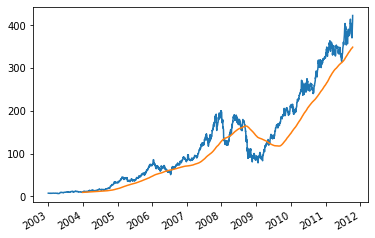

In [214]:
#17.1 Pandas rolling window. Summarise last 250 points 
#     and bring them forward
_=close_px.AAPL.plot()
_=close_px.AAPL.rolling(250).mean().plot()

In [ ]:
# 17.2
# Refer: https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.rolling.html
# rolling(
#           window, # Size of the moving window.
#                   # This is the number of observations 
#                   # used for calculating the statistic.
#                   # Each window will be a fixed size.
#           min_periods=None,
#           center=False,
#           win_type=None,
#           on=None,
#           axis=0, closed=None)

In [ ]:
# 17.3
# To understand rolling forward, let us do one
#  simple experiment. Just average last two points
#   and create a new column:


close_px['avg2'] = close_px['AAPL'].rolling(2).mean()
close_px['sum2'] = close_px['AAPL'].rolling(2).sum()
close_px[['AAPL', 'avg2','sum2']].head(10)


####Simple Experiment--II

In [299]:
# 18.0 Create a date-range from 1st March to 16th March
dr = pd.date_range(start = '03/01/2021', end = '03/16/2021').to_list()

# 18.0.1 Create a data-frame
xy = pd.DataFrame(
                    {
                      "SchoolHoliday" : [1,0,1,1,0,1, 0,0,0,0,1,1, 0,0,1,0] * 2,
                      "StateHoliday" : [0,0,0,1,0,1, 1,0,1,0,1,1, 0,1,0,1] * 2, 
                      "Promo"        : [1,1,0,0,1,0,0,1,1,1,0,0,1,0,0,1] * 2,
                      "date_fld"     : dr * 2,
                      "Store"        : [1]* 16 + [2]* 16,
                      "price"    : np.random.normal(loc = 0.24, scale=1, size = (32,) )
                    }
                  )
# 18.0.3 Shuffle the DataFrame rows 
xy = xy.sample(frac = 1)  
xy.head()

,SchoolHoliday,StateHoliday,Promo,date_fld,Store,price
2,1,0,0,2021-03-03,1,0.808150
25,0,0,1,2021-03-10,2,-0.546181
26,1,1,0,2021-03-11,2,-0.987041
14,1,0,0,2021-03-15,1,0.952635
6,0,1,0,2021-03-07,1,-0.600440


In [300]:
df = xy.set_index('date_fld')
df.shape
df.head()

(32, 5)

,SchoolHoliday,StateHoliday,Promo,Store,price
date_fld,,,,,
2021-03-03,1,0,0,1,0.808150
2021-03-10,0,0,1,2,-0.546181
2021-03-11,1,1,0,2,-0.987041
2021-03-15,1,0,0,1,0.952635
2021-03-07,0,1,0,1,-0.600440


In [304]:
columns = ['SchoolHoliday', 'StateHoliday', 'Promo']
bwd_xy = df[['Store','SchoolHoliday', 'StateHoliday', 'Promo']].sort_index().groupby("Store").rolling(2, min_periods=1).sum()

In [305]:
bwd_xy

Store  SchoolHoliday  StateHoliday  Promo
Store date_fld                                             
1     2021-03-01    1.0            1.0           0.0    1.0
      2021-03-02    2.0            1.0           0.0    2.0
      2021-03-03    2.0            1.0           0.0    1.0
      2021-03-04    2.0            2.0           1.0    0.0
      2021-03-05    2.0            1.0           1.0    1.0
      2021-03-06    2.0            1.0           1.0    1.0
      2021-03-07    2.0            1.0           2.0    0.0
      2021-03-08    2.0            0.0           1.0    1.0
      2021-03-09    2.0            0.0           1.0    2.0
      2021-03-10    2.0            0.0           1.0    2.0
      2021-03-11    2.0            1.0           1.0    1.0
      2021-03-12    2.0            2.0           2.0    0.0
      2021-03-13    2.0            1.0           1.0    1.0
      2021-03-14    2.0            0.0           1.0    1.0
      2021-03-15    2.0            1.0           1.0    0.0
      2021-03-16    2.0            1.0           1.0    1.0
2     2021-03-01    2.0            1.0           0.0    1.0
      2021-03-02    4.0            1.0           0.0    2.0
      2021-03-03    4.0            1.0           0.0    1.0
      2021-03-04    4.0            2.0           1.0    0.0
      2021-03-05    4.0            1.0           1.0    1.0
      2021-03-06    4.0            1.0           1.0    1.0
      2021-03-07    4.0            1.0           2.0    0.0
      2021-03-08    4.0            0.0           1.0    1.0
      2021-03-09    4.0            0.0           1.0    2.0
      2021-03-10    4.0            0.0           1.0    2.0
      2021-03-11    4.0            1.0           1.0    1.0
      2021-03-12    4.0            2.0           2.0    0.0
      2021-03-13    4.0            1.0           1.0    1.0
      2021-03-14    4.0            0.0           1.0    1.0
      2021-03-15    4.0            1.0           1.0    0.0
      2021-03-16    4.0            1.0           1.0    1.0

In [324]:
# https://stackoverflow.com/a/18835121/3282777
xx = bwd_xy.iloc[bwd_xy.index.get_level_values('Store') == 1]

In [325]:
xx = xx.drop(columns = ['Store'])
xx


SchoolHoliday  StateHoliday  Promo
Store date_fld                                      
1     2021-03-01            1.0           0.0    1.0
      2021-03-02            1.0           0.0    2.0
      2021-03-03            1.0           0.0    1.0
      2021-03-04            2.0           1.0    0.0
      2021-03-05            1.0           1.0    1.0
      2021-03-06            1.0           1.0    1.0
      2021-03-07            1.0           2.0    0.0
      2021-03-08            0.0           1.0    1.0
      2021-03-09            0.0           1.0    2.0
      2021-03-10            0.0           1.0    2.0
      2021-03-11            1.0           1.0    1.0
      2021-03-12            2.0           2.0    0.0
      2021-03-13            1.0           1.0    1.0
      2021-03-14            0.0           1.0    1.0
      2021-03-15            1.0           1.0    0.0
      2021-03-16            1.0           1.0    1.0

In [320]:
xx['SchoolHoliday'].values

array([1., 1., 1., 2., 1., 1., 1., 0., 0., 0., 1., 2., 1., 0., 1., 1.])

In [329]:
sk =  df.loc[df['Store'] == 1, :].sort_index().drop(columns = ['Store', 'price'])
sk['schoolholiday'] = xx['SchoolHoliday'].values
sk['promo'] = xx['Promo'].values
sk['stateholiday'] = xx['StateHoliday'].values
sk[['SchoolHoliday', 'schoolholiday', 'Promo', 'promo','StateHoliday', 'stateholiday']]

,SchoolHoliday,schoolholiday,Promo,promo,StateHoliday,stateholiday
date_fld,,,,,,
2021-03-01,1,1.0,1,1.0,0,0.0
2021-03-02,0,1.0,1,2.0,0,0.0
2021-03-03,1,1.0,0,1.0,0,0.0
2021-03-04,1,2.0,0,0.0,1,1.0
2021-03-05,0,1.0,1,1.0,0,1.0
2021-03-06,1,1.0,0,1.0,1,1.0
2021-03-07,0,1.0,0,0.0,1,2.0
2021-03-08,0,0.0,1,1.0,0,1.0
2021-03-09,0,0.0,1,2.0,1,1.0


In [259]:
bwd.shape  # (32, 4)
bwd.head()
bwd.tail()
df.loc[df['Store'] == 1, :].sort_index().head()

(32, 4)

Store  SchoolHoliday  StateHoliday  Promo
Store date_fld                                             
1     2021-03-01    1.0            1.0           0.0    1.0
      2021-03-02    2.0            1.0           0.0    2.0
      2021-03-03    2.0            1.0           0.0    1.0
      2021-03-04    2.0            2.0           1.0    0.0
      2021-03-05    2.0            1.0           1.0    1.0

Store  SchoolHoliday  StateHoliday  Promo
Store date_fld                                             
2     2021-03-12    4.0            2.0           2.0    0.0
      2021-03-13    4.0            1.0           1.0    1.0
      2021-03-14    4.0            0.0           1.0    1.0
      2021-03-15    4.0            1.0           1.0    0.0
      2021-03-16    4.0            1.0           1.0    1.0

,SchoolHoliday,StateHoliday,Promo,Store,price
date_fld,,,,,
2021-03-01,1,0,1,1,-0.559275
2021-03-02,0,0,1,1,-0.162986
2021-03-03,1,0,0,1,0.108771
2021-03-04,1,1,0,1,-1.005944
2021-03-05,0,0,1,1,-1.122124


,SchoolHoliday,StateHoliday,Promo,Store,price
date_fld,,,,,
2021-03-12,1,1,0,1,-1.347569
2021-03-16,0,1,1,1,-1.528686
2021-03-07,0,1,0,1,1.142124
2021-03-09,0,1,1,1,0.184610
2021-03-10,0,0,1,1,-1.043665
2021-03-06,1,1,0,1,0.547096
2021-03-11,1,1,0,1,-0.241190
2021-03-13,0,0,1,1,2.427245
2021-03-05,0,0,1,1,-1.122124


In [249]:
bwd.index

MultiIndex([(1, '2021-03-01'),
            (1, '2021-03-02'),
            (1, '2021-03-03'),
            (1, '2021-03-04'),
            (1, '2021-03-05'),
            (1, '2021-03-06'),
            (1, '2021-03-07'),
            (1, '2021-03-08'),
            (1, '2021-03-09'),
            (1, '2021-03-10'),
            (1, '2021-03-11'),
            (1, '2021-03-12'),
            (1, '2021-03-13'),
            (1, '2021-03-14'),
            (1, '2021-03-15'),
            (1, '2021-03-16'),
            (2, '2021-03-01'),
            (2, '2021-03-02'),
            (2, '2021-03-03'),
            (2, '2021-03-04'),
            (2, '2021-03-05'),
            (2, '2021-03-06'),
            (2, '2021-03-07'),
            (2, '2021-03-08'),
            (2, '2021-03-09'),
            (2, '2021-03-10'),
            (2, '2021-03-11'),
            (2, '2021-03-12'),
            (2, '2021-03-13'),
            (2, '2021-03-14'),
            (2, '2021-03-15'),
            (2, '2021-03-16')],
       

#### Next on real data

We'll now use window functions in pandas to calculate rolling quantities. Here we're sorting by date (`sort_index()`) and counting the number of events of interest (`sum()`) defined in columns in the following week (`rolling()`), grouped by Store (groupby()). We do the same in the opposite direction.


In [196]:
# Do rolling store by store
columns = ['SchoolHoliday', 'StateHoliday', 'Promo']
bwd = joined[['Store']+columns].sort_index().groupby("Store").rolling(7, min_periods=1).sum()

In [199]:
bwd.shape
bwd.head()

(1017209, 4)

Store  SchoolHoliday  StateHoliday  Promo
Store Date                                                 
1     2013-01-01    1.0            1.0           1.0    0.0
      2013-01-02    2.0            2.0           1.0    0.0
      2013-01-03    3.0            3.0           1.0    0.0
      2013-01-04    4.0            4.0           1.0    0.0
      2013-01-05    5.0            5.0           1.0    0.0

In [ ]:
joined['Store'].value_counts().sort_values(ascending = False)

In [211]:
bwd['Store'].value_counts().sort_values(ascending = False)

420.0     942
840.0     942
1680.0    941
1260.0    941
2100.0    941
630.0     941
336.0     941
210.0     941
1050.0    941
672.0     941
1092.0    941
168.0     941
588.0     941
84.0      941
882.0     940
2520.0    940
1512.0    940
1596.0    940
980.0     940
1848.0    940
2184.0    940
1764.0    940
1470.0    940
1932.0    940
560.0     940
714.0     940
1890.0    940
294.0     940
1176.0    940
462.0     940
42.0      940
126.0     940
378.0     940
966.0     940
280.0     940
546.0     940
798.0     940
2856.0    939
315.0     939
70.0      939
1820.0    939
1722.0    939
56.0      939
2310.0    939
770.0     939
308.0     939
868.0     939
2688.0    939
1064.0    939
616.0     939
3108.0    939
3360.0    939
910.0     939
735.0     939
945.0     939
2352.0    939
476.0     939
2772.0    939
1120.0    939
2058.0    939
1540.0    939
525.0     939
1386.0    939
2268.0    939
2730.0    939
644.0     939
3276.0    939
3192.0    939
1638.0    939
2604.0    939
1554.0    939
2226.0

In [204]:
bwd.loc[bwd['Store'] == 4, : ].head()

,,Store,SchoolHoliday,StateHoliday,Promo
Store,Date,,,,
1,2013-01-04,4.0,4.0,1.0,0.0
2,2013-01-02,4.0,2.0,1.0,0.0
4,2013-01-01,4.0,1.0,1.0,0.0


In [ ]:
fwd = df[['Store']+columns].sort_index(ascending=False
                                      ).groupby("Store").rolling(7, min_periods=1).sum()

In [ ]:
fwd.head()

Store  SchoolHoliday  StateHoliday  Promo
Store Date                                                 
1     2015-07-31    1.0            1.0           0.0    1.0
      2015-07-30    2.0            2.0           0.0    2.0
      2015-07-29    3.0            3.0           0.0    3.0
      2015-07-28    4.0            4.0           0.0    4.0
      2015-07-27    5.0            5.0           0.0    5.0